## Imports and functions ##

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datasets import load_basic_motions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
import warnings
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

## Import custom functions from 'pre_processing.py' ##
try:
    import importlib
    importlib.reload(pp)
except NameError: # It hasn't been imported yet
    import pre_processing as pp
    
## Import custom functions from 'CNN.py' ##
try:
    import importlib
    importlib.reload(cnn)
except NameError: # It hasn't been imported yet
    import CNN as cnn

## Import custom functions from 'LSTMFCN.py' ##
try:
    import importlib
    importlib.reload(LSTM)
except NameError: # It hasn't been imported yet
    import LSTMFCN as LSTM
    
fnirs_data = r'C:\Users\61407\mental-health-modelling\data\fNIRS\bandpass_filtered_whole_data'
task_accuracy_data = r'C:\Users\61407\mental-health-modelling\data\fNIRS\task_accuracy'

## Data inspection ##

### First just check one file (one subject) of the fNIRS data ###

In [2]:
subject_ID = os.listdir(fnirs_data)[0].split('.csv')[0]
subject_fnirs_path = os.path.join(fnirs_data, f'{subject_ID}.csv')
subject_fnirs = pd.read_csv(subject_fnirs_path)
display(subject_fnirs.head(151))

AB_I_O  AB_PHI_O   AB_I_DO  AB_PHI_DO    CD_I_O  CD_PHI_O   CD_I_DO  \
0   -0.198291  0.335677 -0.560790  -0.056042  0.460231  0.271119 -0.645892   
1   -0.195651  0.297210 -0.580712  -0.032170  0.524553  0.208284 -0.681370   
2   -0.192790  0.275041 -0.600446  -0.012370  0.585149  0.162781 -0.716632   
3   -0.189943  0.271573 -0.619751   0.002192  0.641092  0.133816 -0.750998   
4   -0.187401  0.288043 -0.638379   0.010818  0.691434  0.119983 -0.783748   
..        ...       ...       ...        ...       ...       ...       ...   
146 -0.276677  0.155211 -0.620998   0.269778  0.238290  1.063947 -0.679526   
147 -0.256185  0.219927 -0.625140   0.262394  0.239653  1.070388 -0.668889   
148 -0.232586  0.295836 -0.628870   0.249107  0.242884  1.093503 -0.657132   
149 -0.205987  0.379350 -0.631916   0.230288  0.248417  1.132345 -0.644564   
150 -0.176651  0.466827 -0.634041   0.206568  0.256645  1.184934 -0.631498   

     CD_PHI_DO  label  
0     0.198804      0  
1     0.202136      0  
2     0.194758      0  
3     0.176938      0  
4     0.149429      0  
..         ...    ...  
146   0.110723      0  
147   0.113302      0  
148   0.105743      0  
149   0.088886      0  
150   0.064102      0  

[151 rows x 9 columns]

**1. Features**
- AB_I_O, AB_I_DO: Intensity of oxy & deoxy from detector AB.
- CD_I_O, CD_I_DO: Intensity of oxy & deoxy from detector CD.
- AB_PHI_O, AB_PHI_DO: Phase of oxy & deoxy from detector AB.
- CD_PHI_O, CD_PHI_DO: Phase of oxy & deoxy from detector CD.

**2. Rows**
- Each row represents a single time step of sensor recording measurement

**3. Other columns**
- "label" represents the difficulty of the task ranging from 0-4

### Next check task accuracy data of the same subject ###

In [3]:
subject_accuracy = pd.read_csv(os.path.join(task_accuracy_data, f'{subject_ID}.csv'))
subject_accuracy.sort_values('acc')

task_name task_type    acc
9    task_10    3_back  0.700
3     task_4    3_back  0.800
6     task_7    3_back  0.825
12   task_13    3_back  0.825
2     task_3    2_back  0.900
8     task_9    2_back  0.950
14   task_15    1_back  0.975
0     task_1    0_back  1.000
1     task_2    1_back  1.000
4     task_5    1_back  1.000
5     task_6    2_back  1.000
7     task_8    0_back  1.000
10   task_11    0_back  1.000
11   task_12    1_back  1.000
13   task_14    0_back  1.000
15   task_16    2_back  1.000

## Combine data from all subjects ##
- will scale the data upon upload, to scale data individually for each subject

In [15]:
all_data = pp.upload_all_subjects(fnirs_data, scaled=True)
# First split data into task blocks by assigning a block label
all_grouped_dataframes, all_block_change_idx = pp.detect_block_changes(all_data, label='difficulty')
block_labelled_data = pd.concat(all_grouped_dataframes)

# Define a function to convert time series representation over multiple rows of a pandas into a single array
def nested_numpy(group):
    return pd.Series([group[col].to_numpy() for col in group.columns if col != 'difficulty'])

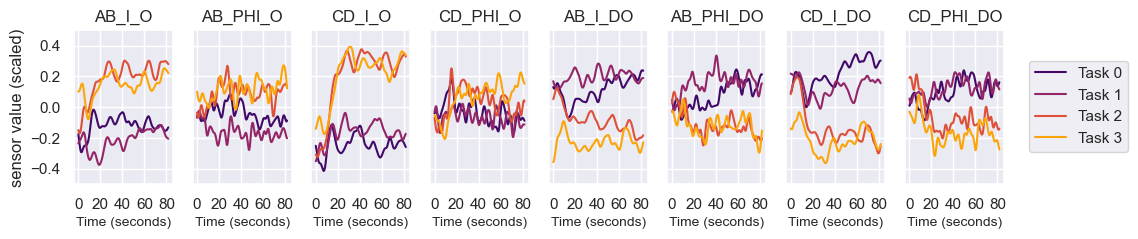

In [16]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=8,
                       figsize=(12,2),
                       sharey=True, sharex=True)
groups = block_labelled_data.groupby(['difficulty'])
cmap = sns.color_palette("inferno", n_colors=4)

for group, color in zip(groups.groups.keys(), cmap):
    group_df = groups.get_group(group)
    group_array = np.array([df.drop('difficulty', axis=1).to_numpy() for key, df in group_df.groupby(group_df.index.get_level_values(0))])
    
    for col, (channel) in enumerate(group_df.drop('difficulty', axis=1).columns):
        channel_array = group_array[:,:,col]
        channel_mean = channel_array.mean(axis=0)
        channel_sem = channel_array.std(axis=0) / np.sqrt(channel_array.shape[0])
        ax[col].plot(channel_mean, color=color)
#         ax[col].fill_between(x=np.arange(channel_array.shape[1]), 
#                              y1=channel_mean-channel_sem, y2=channel_mean+channel_sem, 
#                              color=color, alpha=0.25)
        ax[col].set_title(channel)
        ax[col].set_ylabel('sensor value (scaled)') if col == 0 else None
        ax[col].set_ylim(-0.5, 0.5)
        ax[col].set_xticks([x*5.2 for x in [0,20,40,60,80]])
        ax[col].set_xticklabels([str(x) for x in [0,20,40,60,80]])
        ax[col].set_xlabel('Time (seconds)', fontsize=10)
fig.legend(['Task 0','Task 1','Task 2','Task 3'], loc='center right', bbox_to_anchor=(1.01, 0.5))
plt.show();
fig.savefig('all_average_traces.png', bbox_inches='tight')

## Is there much variability between subjects? ##

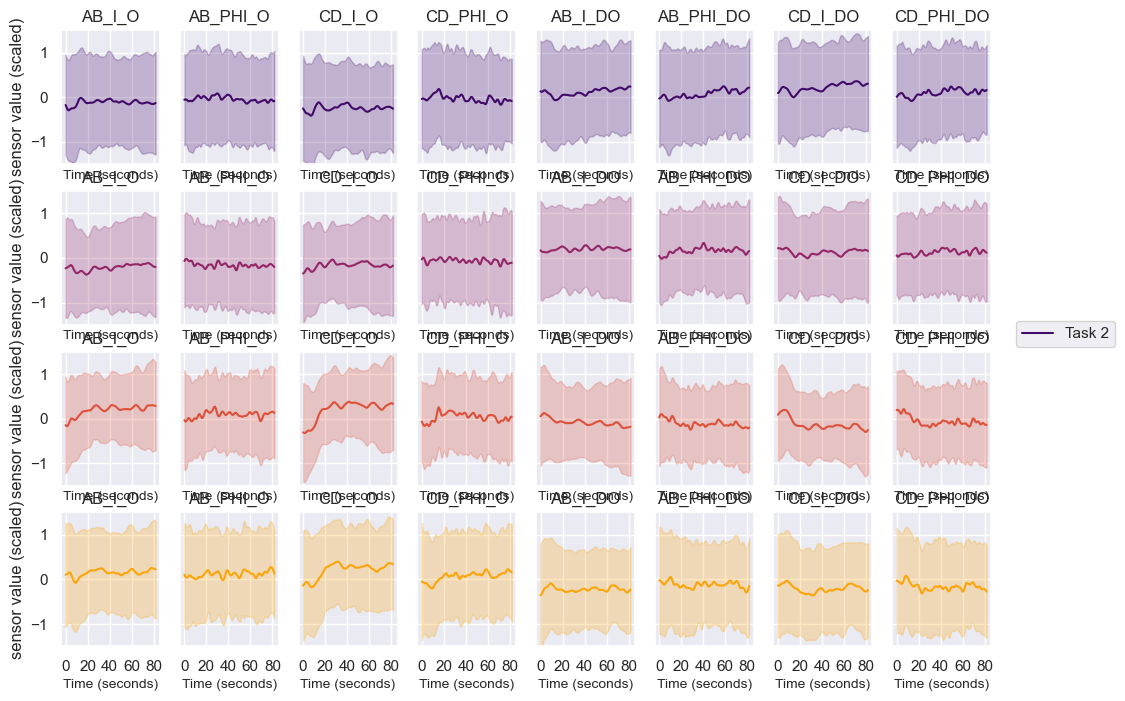

In [21]:
sns.set()
fig, ax = plt.subplots(nrows=4, ncols=8,
                       figsize=(12,8),
                       sharey=True, sharex=True)
groups = block_labelled_data.groupby(['difficulty'])
cmap = sns.color_palette("inferno", n_colors=4)

for row, (group, color) in enumerate(zip(groups.groups.keys(), cmap)):
    group_df = groups.get_group(group)
    group_array = np.array([df.drop('difficulty', axis=1).to_numpy() for key, df in group_df.groupby(group_df.index.get_level_values(0))])

    for col, (channel) in enumerate(group_df.drop('difficulty', axis=1).columns):
        channel_array = group_array[:,:,col]
        channel_mean = channel_array.mean(axis=0)
        channel_sem = channel_array.std(axis=0)# / np.sqrt(channel_array.shape[0])
        ax[row,col].plot(channel_mean, color=color)
        ax[row,col].fill_between(x=np.arange(channel_array.shape[1]), 
                             y1=channel_mean-channel_sem, y2=channel_mean+channel_sem, 
                             color=color, alpha=0.25)
        ax[row,col].set_title(channel)
        ax[row,col].set_ylabel('sensor value (scaled)') if col == 0 else None
        ax[row,col].set_ylim(-1.5,1.5)
        ax[row,col].set_xticks([x*5.2 for x in [0,20,40,60,80]])
        ax[row,col].set_xticklabels([str(x) for x in [0,20,40,60,80]])
        ax[row,col].set_xlabel('Time (seconds)', fontsize=10)
fig.legend(['Task 2'], loc='center right', bbox_to_anchor=(1.01, 0.5))
plt.show();
fig.savefig('Task2_average_traces.png', bbox_inches='tight')

- Huge variability between subjects

## Are there clusters of subjects with similar activity? ##

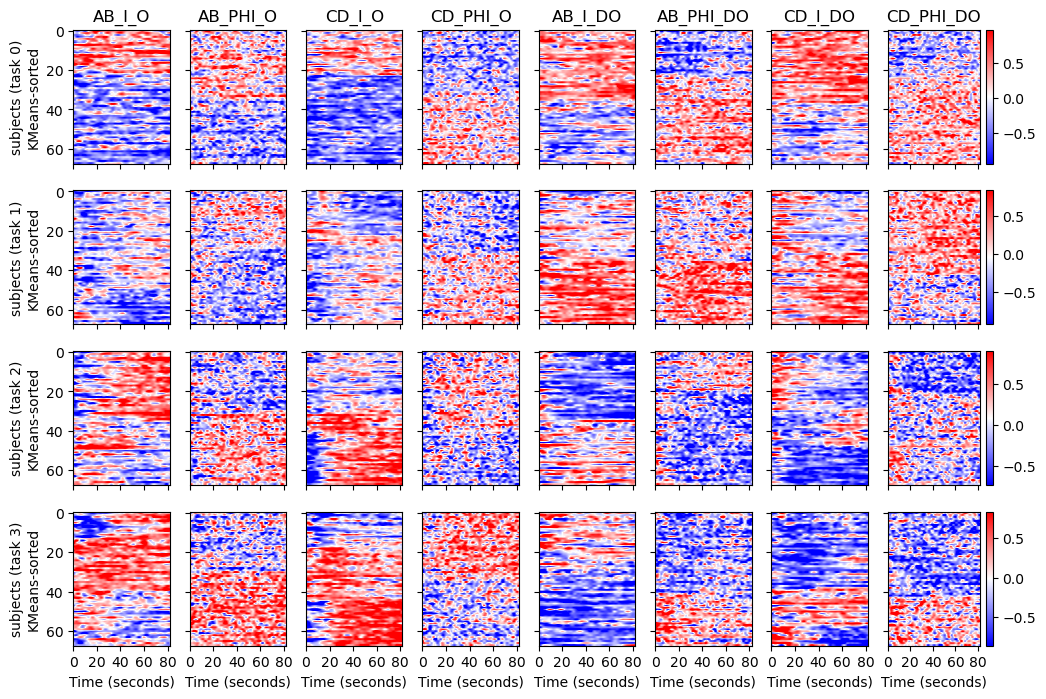

In [22]:
sns.reset_defaults()
fig, ax = plt.subplots(nrows=4, ncols=8,
                       figsize=(12,8),
                       sharey=True, sharex=True,
                       gridspec_kw={'width_ratios':[0.122 for i in range(7)] + [1-(0.122*7)]})
groups = block_labelled_data.groupby(['difficulty'])
cmap = sns.color_palette("Oranges", n_colors=4)

best_ks = {}
for row, (group) in enumerate(groups.groups.keys()):
    best_ks[row] = {}
    group_df = groups.get_group(group)
    
    sub_arrays = []
    sub_groups = group_df.groupby(group_df.index.get_level_values(1))
    for sub in sub_groups.groups:
        sub_df = sub_groups.get_group(sub)
        sub_array = np.array([df.drop('difficulty', axis=1).to_numpy() for block, df in sub_df.groupby(sub_df.index.get_level_values(0))])
        sub_arrays.append(sub_array.mean(axis=0))
    final_array = np.array(sub_arrays)
    vmin, vmax = final_array.mean(axis=1).min(), final_array.mean(axis=1).max()
    
    for col, (channel) in enumerate(group_df.drop('difficulty', axis=1).columns):
        channel_array = final_array[:,:,col]
        
        # Try different values of k and compute silhouette score
        best_k = 0
        best_silhouette = 0
        best_labels = []
        for k in range(2, 11):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(channel_array)
            current_score = silhouette_score(channel_array, labels)
            
            if current_score > best_silhouette:
                best_k = k
                best_silhouette = current_score
                best_labels = labels
        best_ks[row][col] = best_k
        
        # Sort subjects by cluster labels and plot
        cluster_sorted = np.vstack([channel_array[np.where(best_labels == k)] for k in range(best_k)])
        im = ax[row,col].imshow(cluster_sorted, vmin=vmin, vmax=vmax, aspect='auto', cmap='bwr')
        ax[row,col].set_title(channel) if row == 0 else None
        ax[row,col].set_ylabel(f'subjects (task {row})\nKMeans-sorted') if col == 0 else None
        ax[row,col].set_xticks([x*5.2 for x in [0,20,40,60,80]]) if row == 3 else None
        ax[row,col].set_xticklabels([str(x) for x in [0,20,40,60,80]]) if row == 3 else None
        ax[row,col].set_xlabel('Time (seconds)', fontsize=10) if row == 3 else None
        plt.colorbar(im) if col == 7 else None 
plt.show();
fig.savefig('KMeans_avg_heatmaps.png', bbox_inches='tight')

- What was the optimal number of clusters for each task level/channel?

In [36]:
best_k_df = pd.concat([pd.DataFrame(level_dict.values(), level_dict.keys()) for level, level_dict in best_ks.items()], axis=1).T
best_k_df.columns = all_data.drop('difficulty', axis=1).columns
best_k_df.index = ['Task 0', 'Task 1', 'Task 2', 'Task 3']
best_k_df

AB_I_O  AB_PHI_O  CD_I_O  CD_PHI_O  AB_I_DO  AB_PHI_DO  CD_I_DO  \
Task 0       2         2       2         2        2          2        2   
Task 1       2         2       2         2        2          2        2   
Task 2       2         2       3         2        2          2        3   
Task 3       3         2       3         2        2          2        3   

        CD_PHI_DO  
Task 0          2  
Task 1          2  
Task 2          2  
Task 3          2

- There are generally 2 or 3 pretty distinc clusters of subjects in our data (should dig into this further)

## Are there clusters of activity within subject (i.e. between task blocks)? ##

In [23]:
sub_groups = block_labelled_data.groupby(block_labelled_data.index.get_level_values(1))
sub_by_sub_clustering = {}
for sub in sub_groups.groups:
    sub_df = sub_groups.get_group(sub)
    block_arrays = np.array([df.drop('difficulty', axis=1).to_numpy() for block, df in sub_df.groupby(sub_df.index.get_level_values(0))])
    block_labels = np.array([int(x) for x in sub_df.groupby(sub_df.index.get_level_values(0)).mean().difficulty])
    
    # Try different values of k and compute silhouette score
    sub_ks = {}
    for channel, (name) in enumerate(sub_df.drop('difficulty', axis=1).columns):
        channel_array = block_arrays[:,:,channel]
        best_k = 0
        best_silhouette = 0
        best_labels = []
        for k in range(2, 5):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(channel_array)
            current_score = silhouette_score(channel_array, labels)

            if current_score > best_silhouette:
                best_k = k
                best_silhouette = current_score
                best_labels = labels
        sub_ks[name] = {'best_k':best_k, 'cluster_labels':best_labels, 'real_labels':block_labels}
    sub_by_sub_clustering[sub] = sub_ks

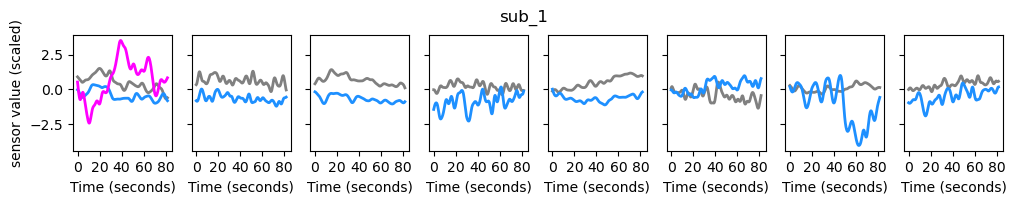

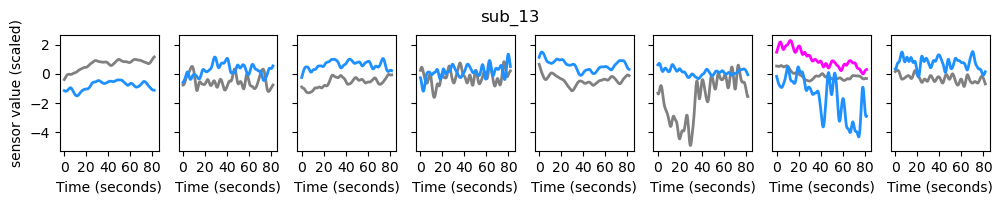

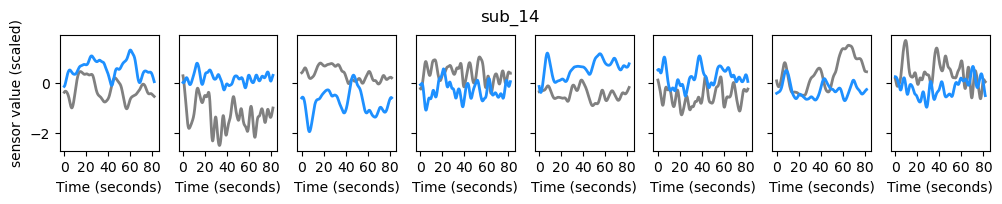

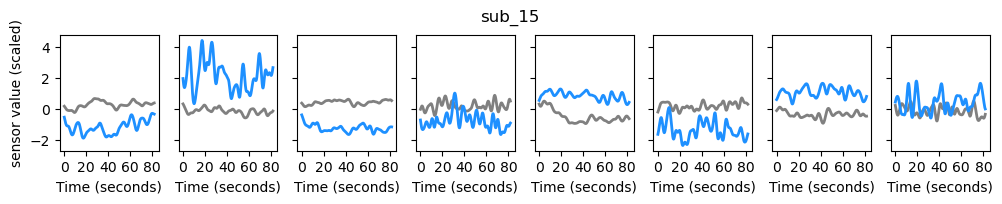

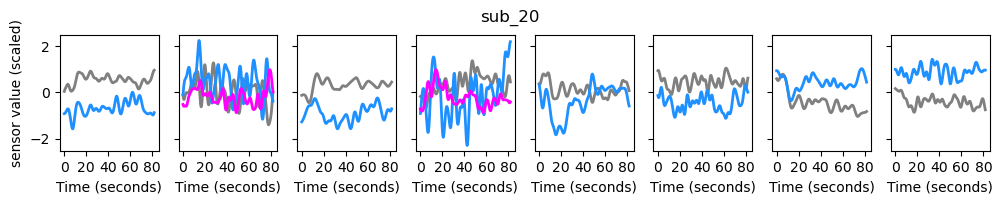

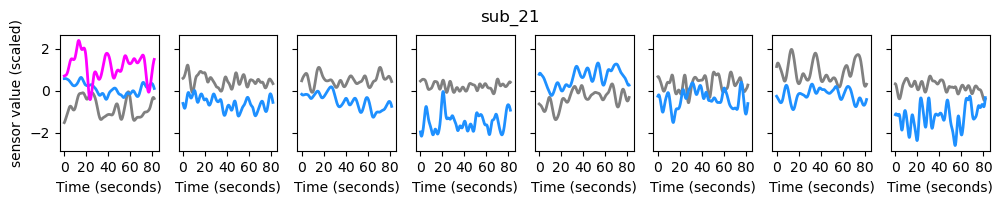

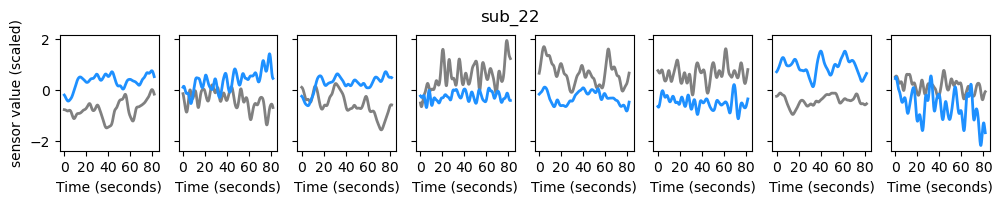

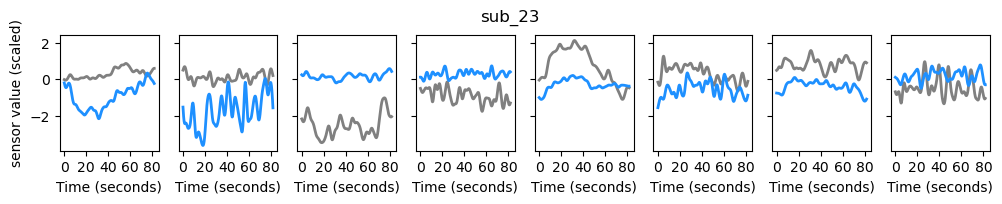

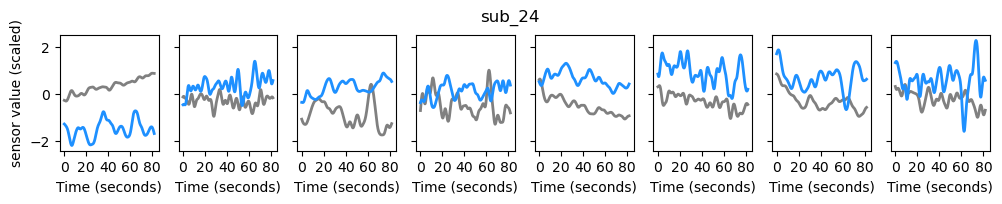

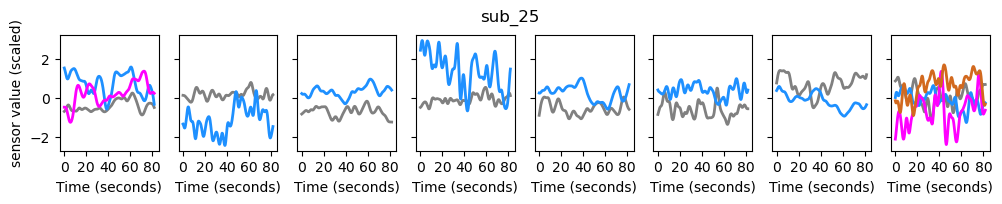

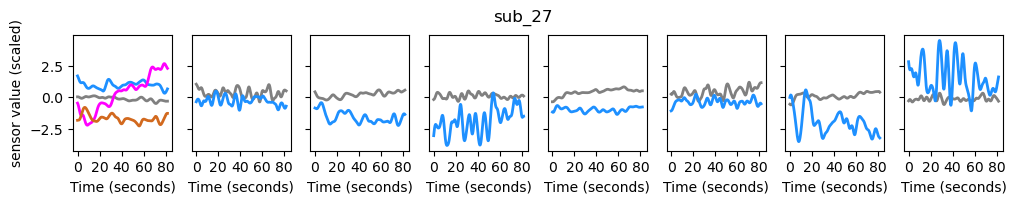

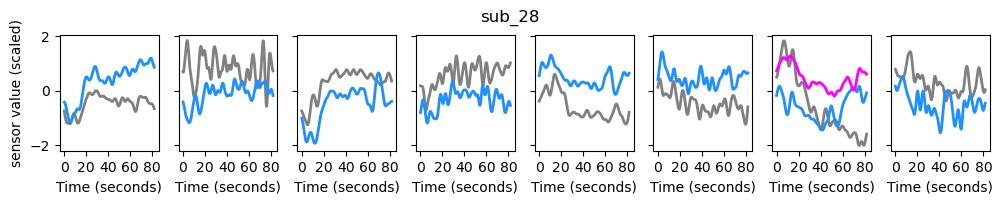

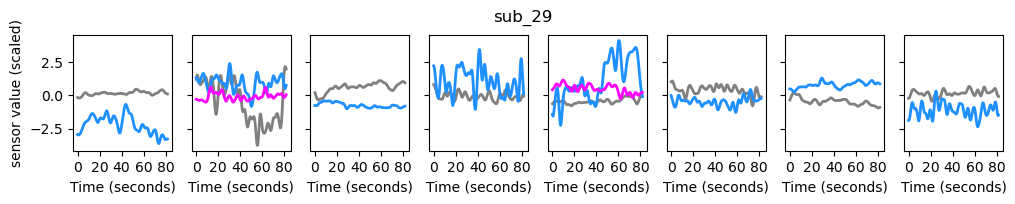

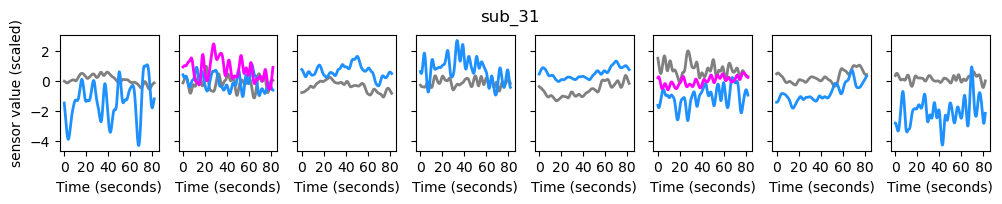

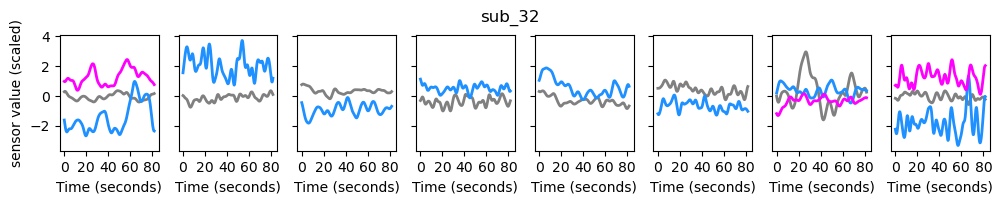

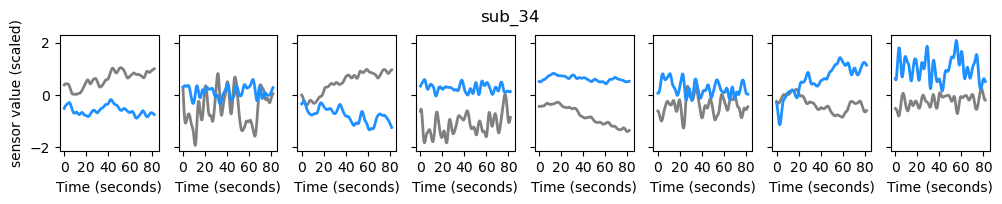

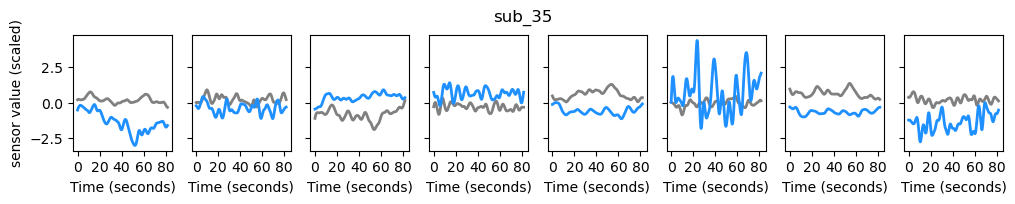

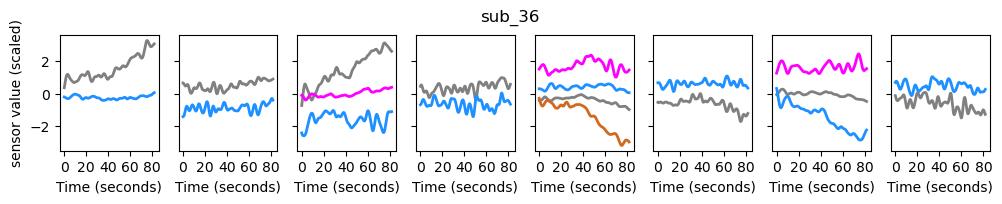

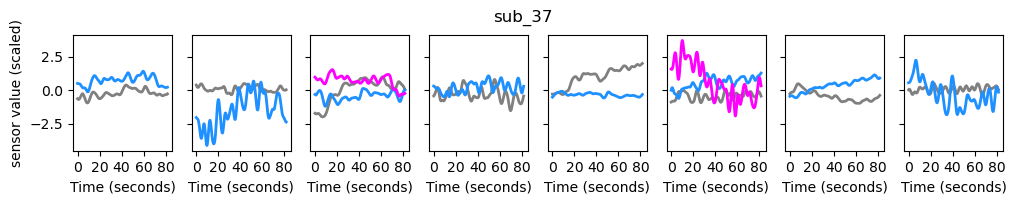

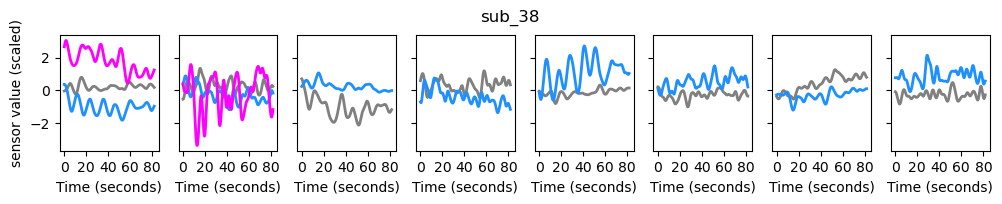

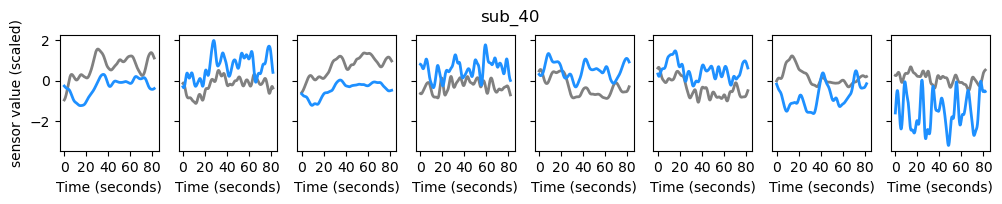

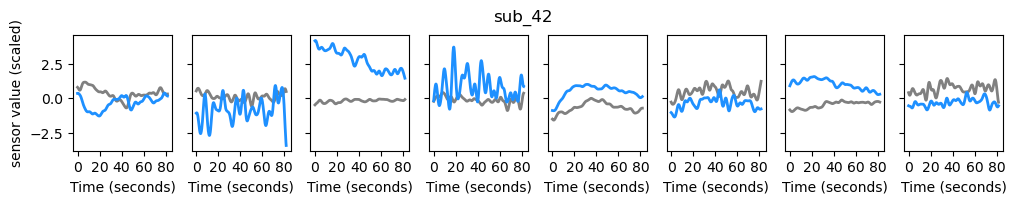

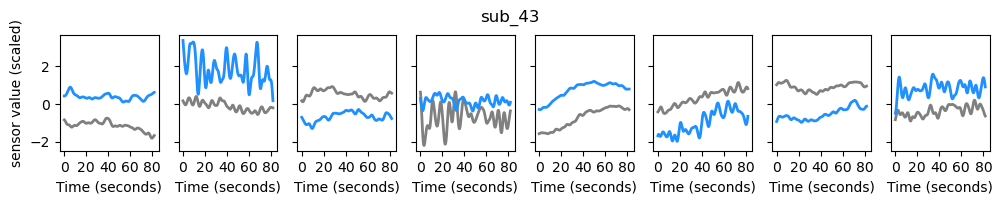

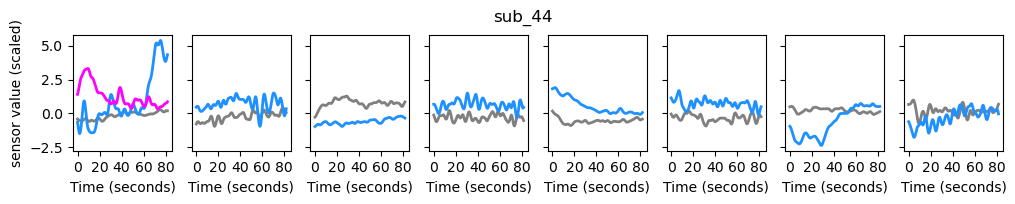

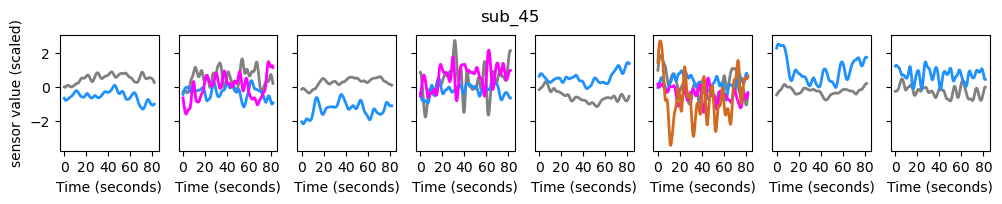

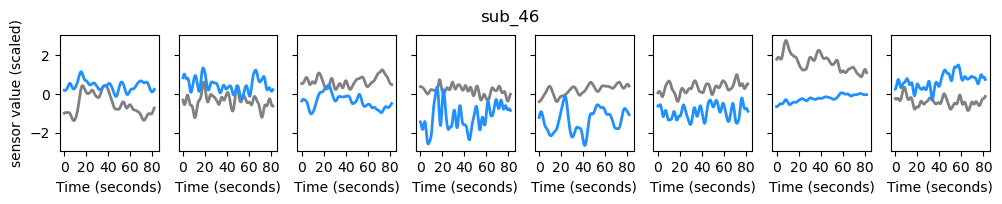

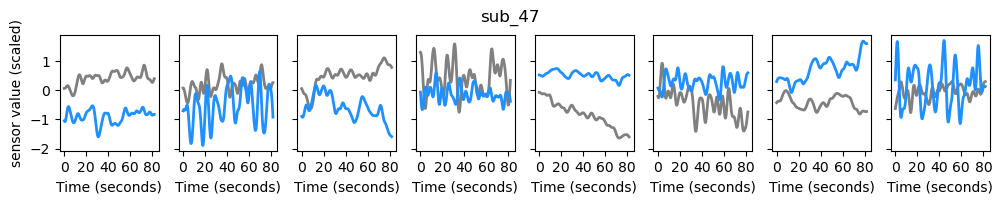

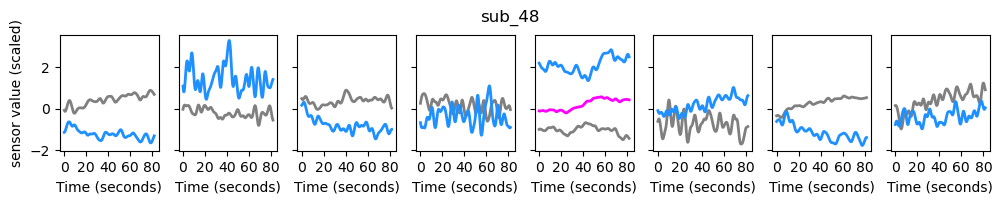

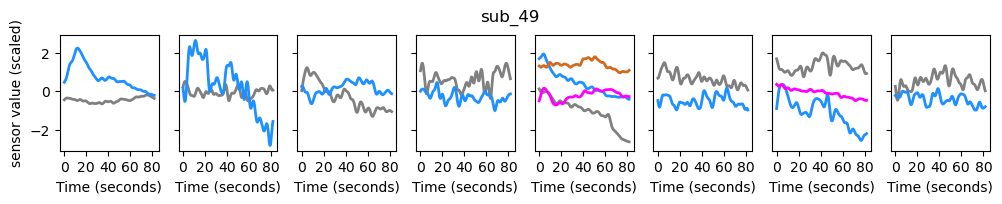

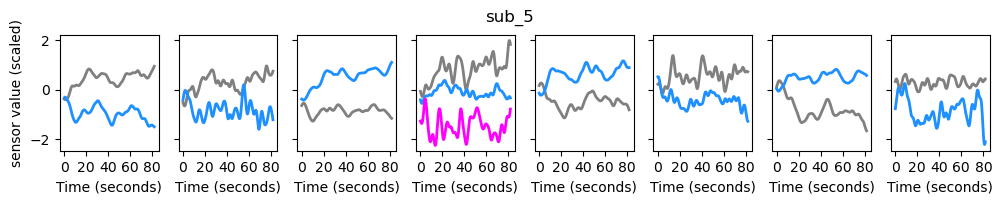

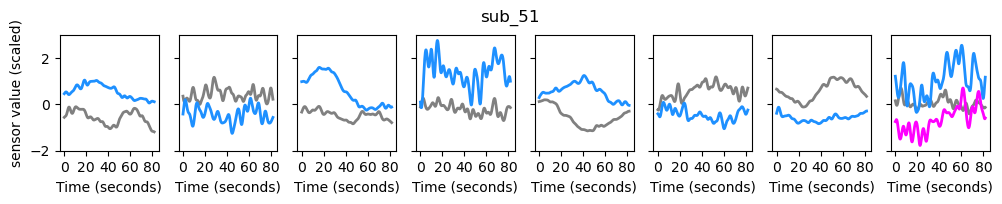

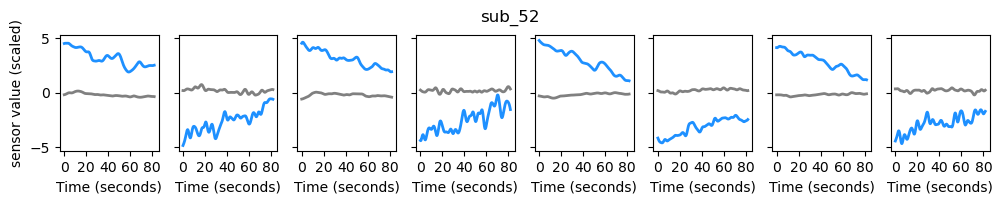

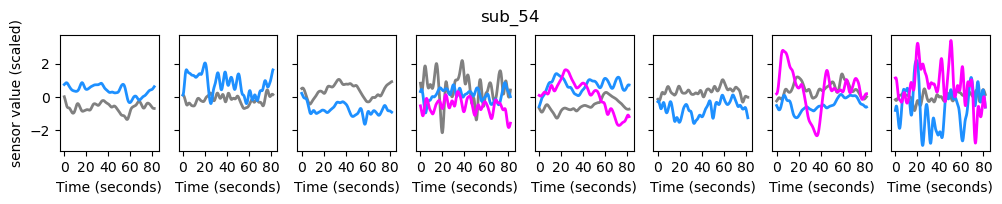

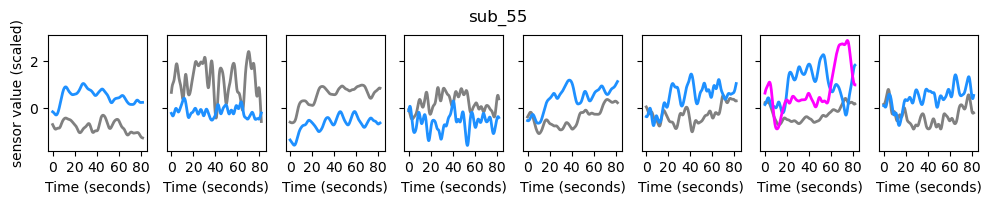

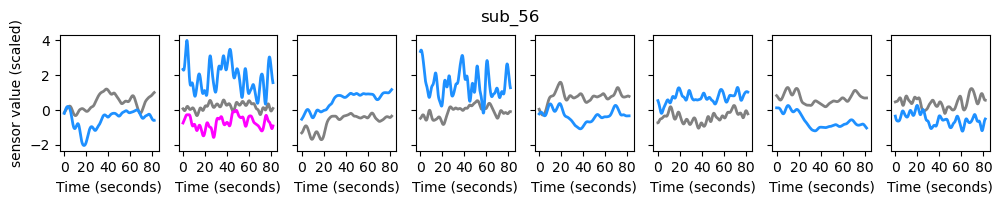

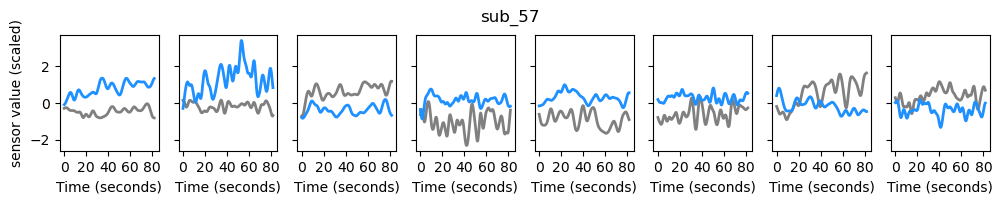

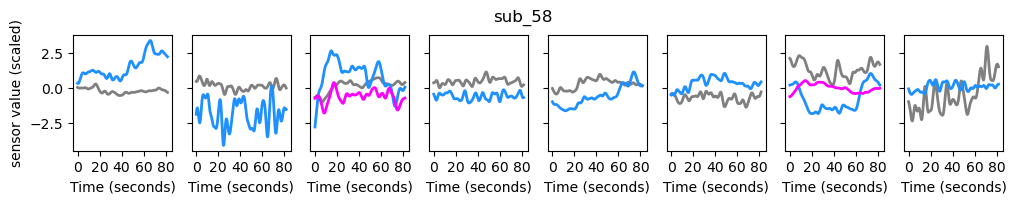

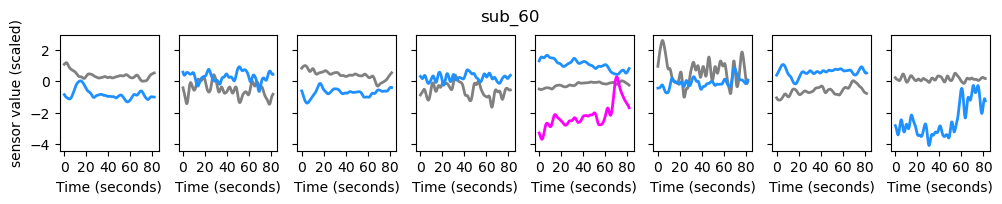

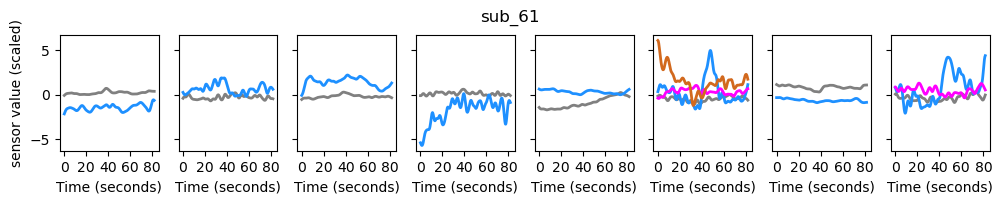

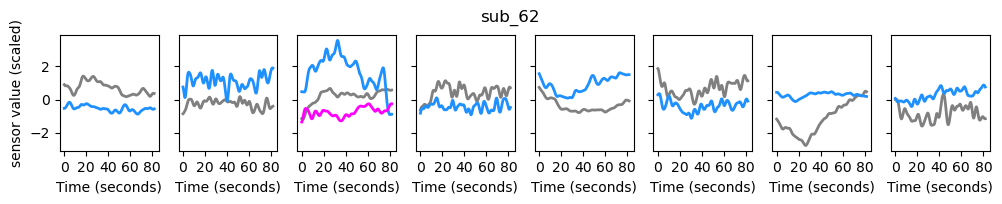

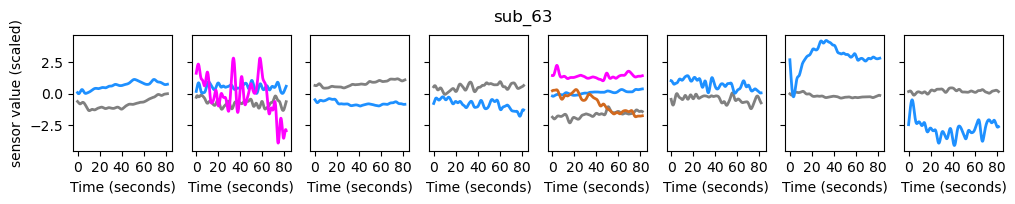

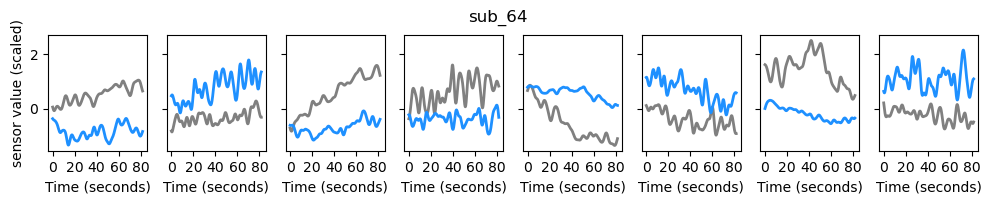

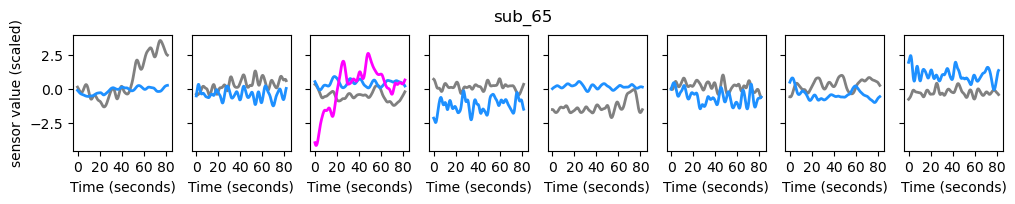

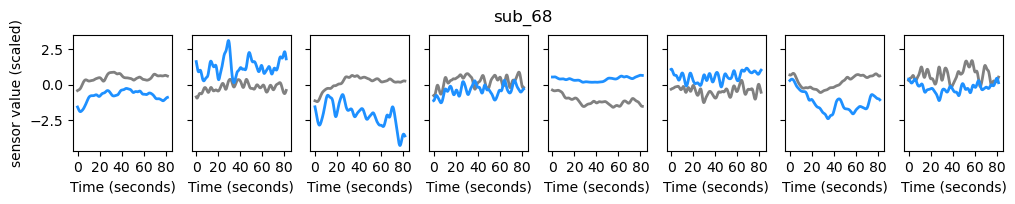

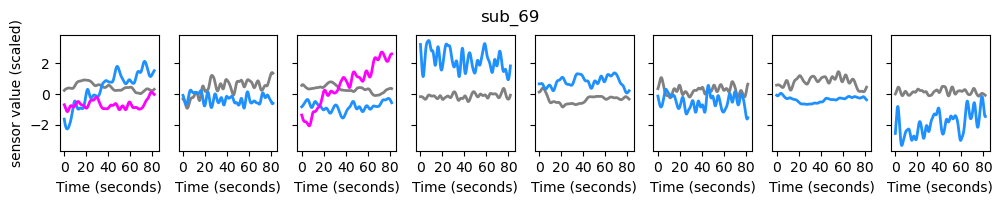

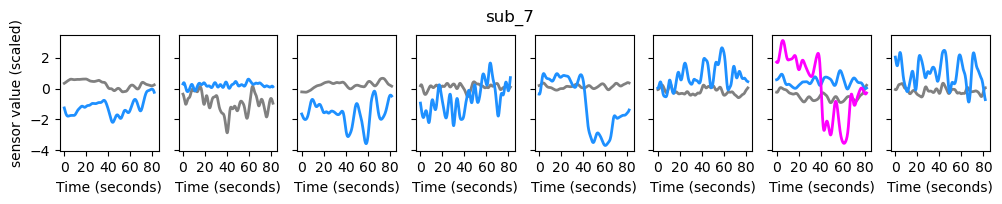

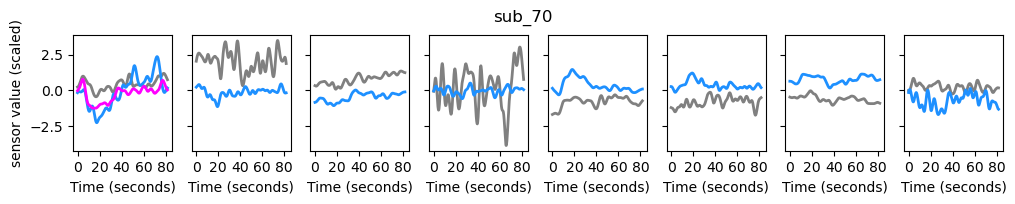

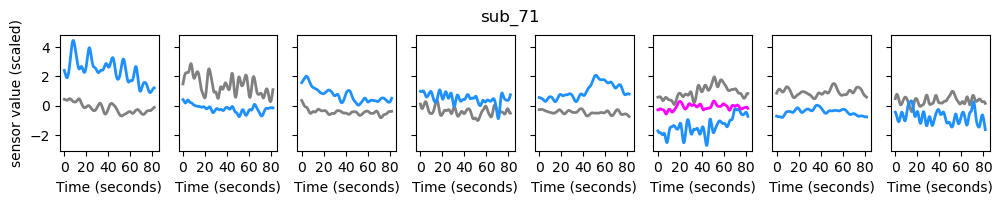

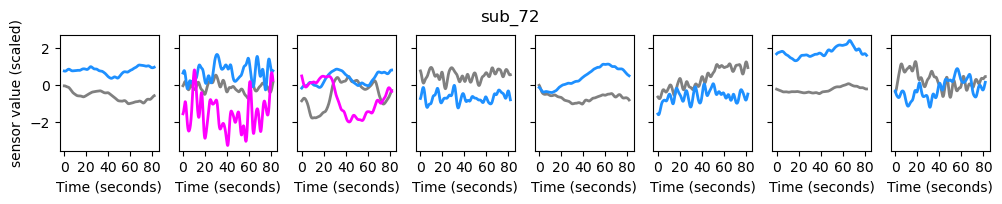

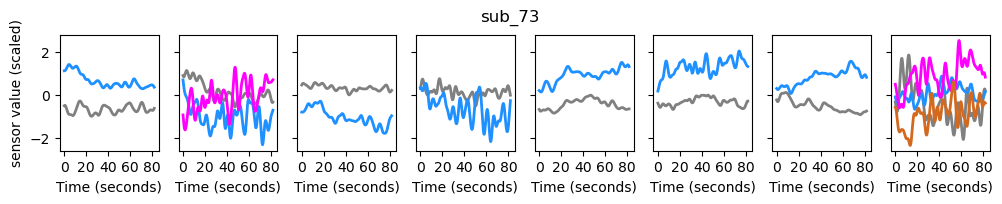

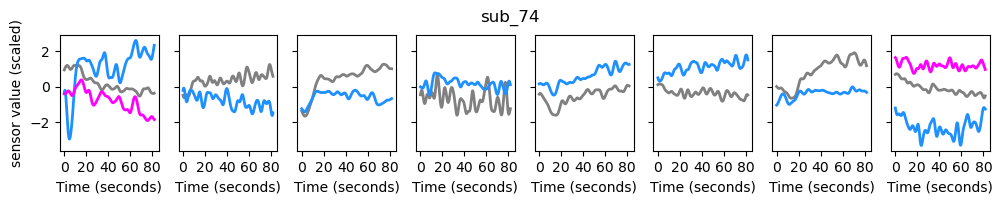

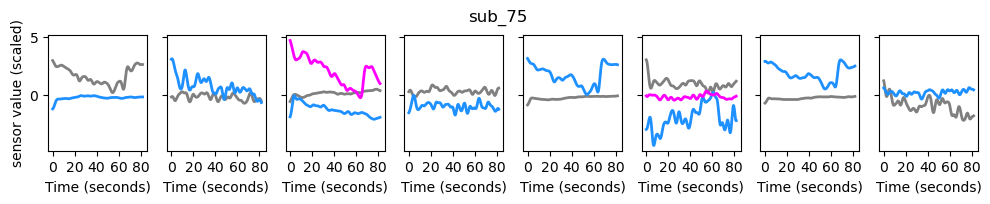

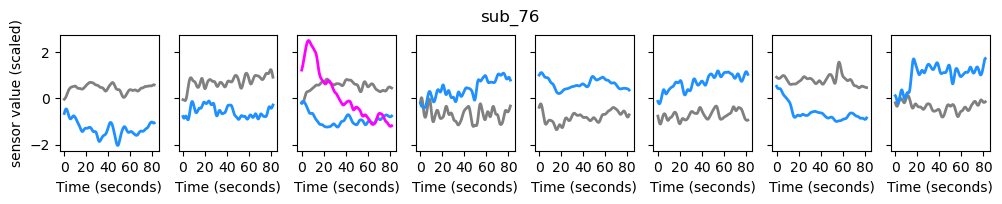

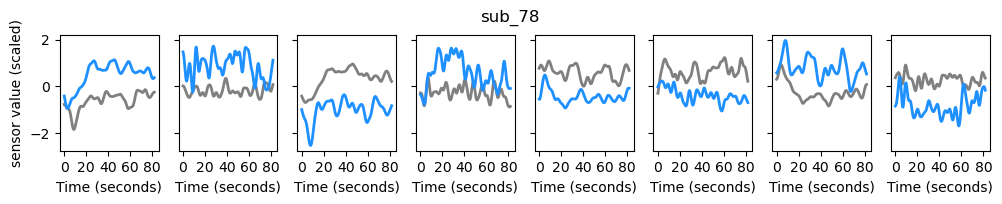

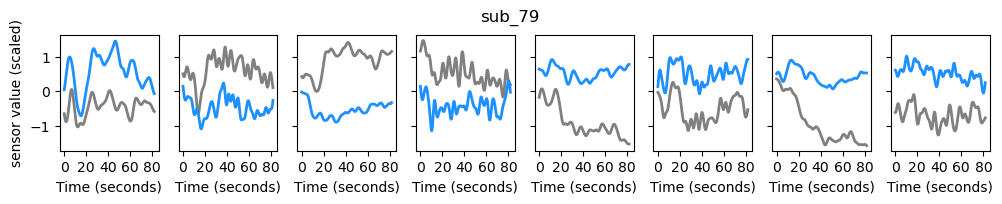

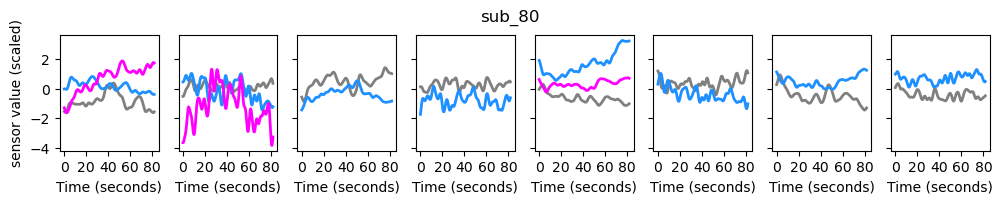

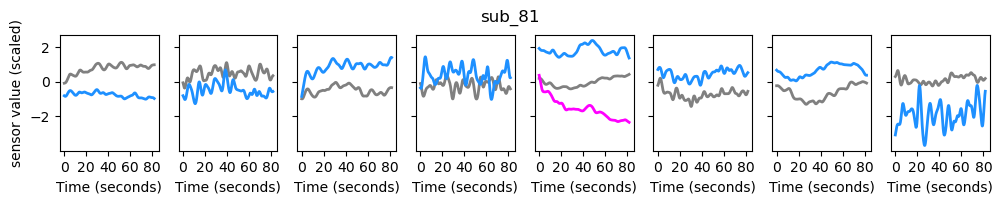

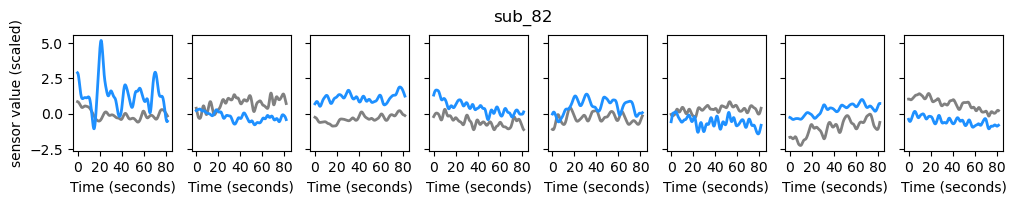

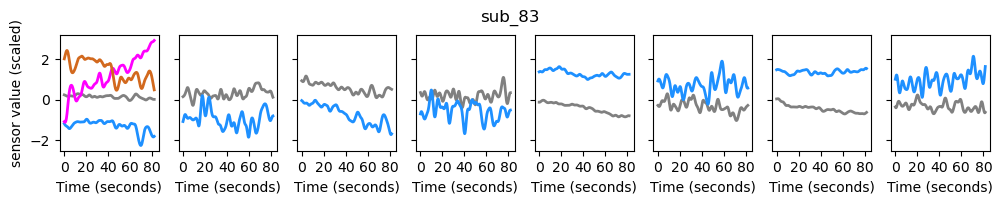

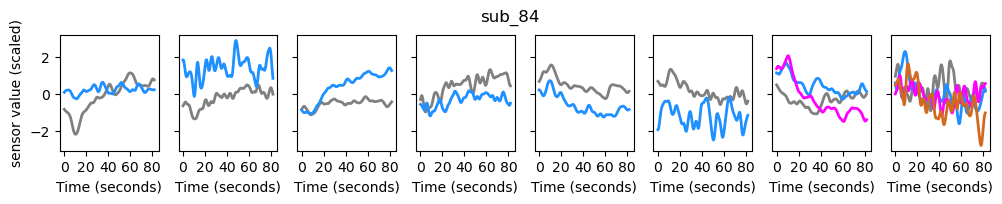

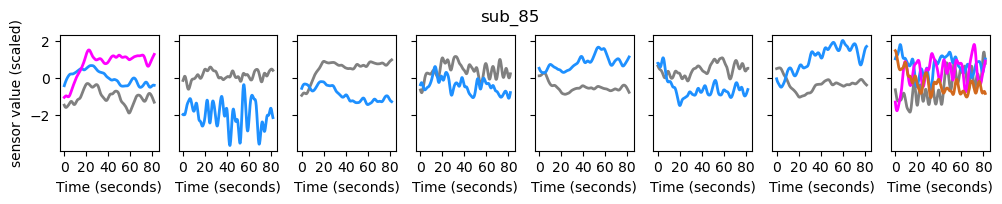

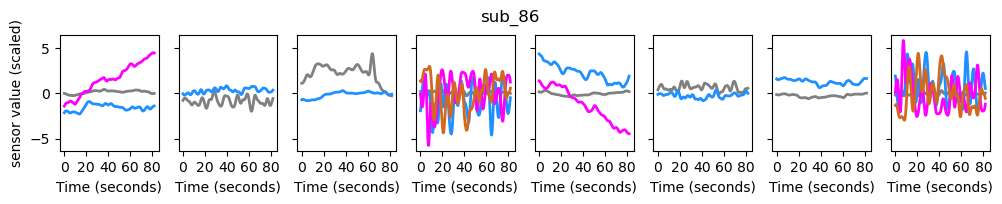

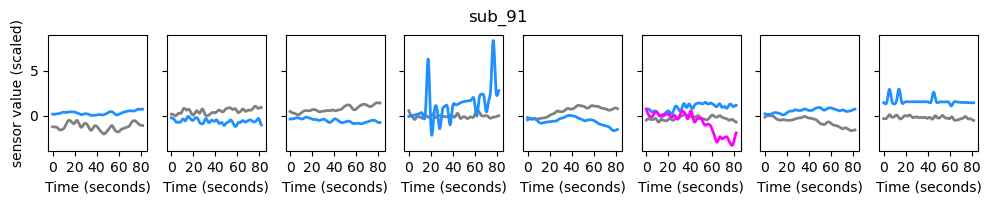

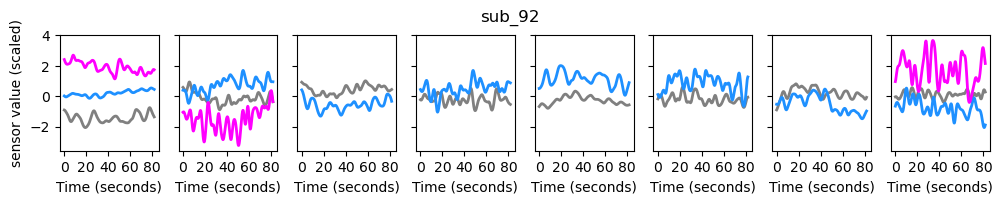

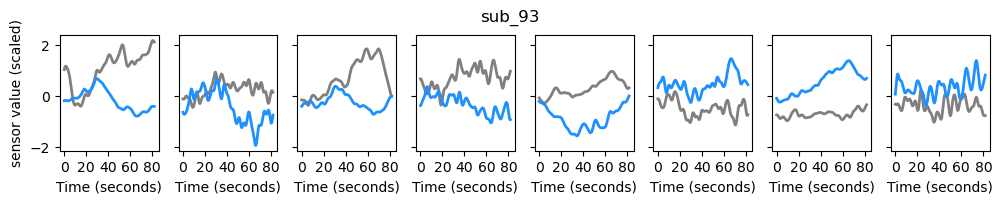

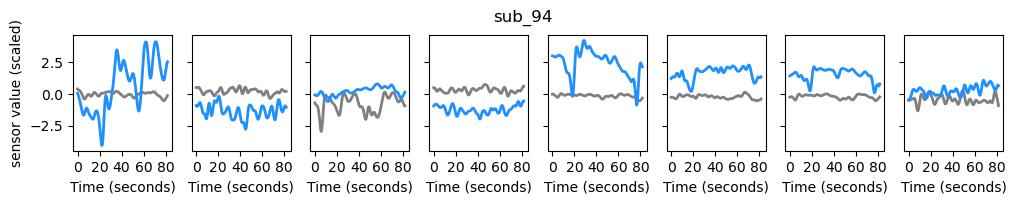

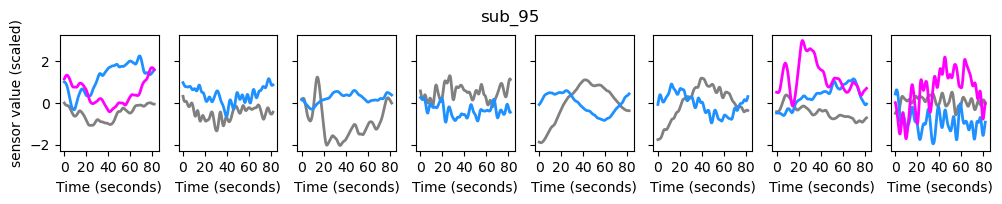

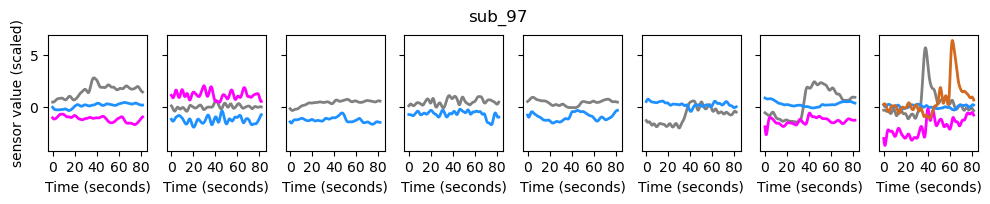

In [24]:
for sub, sub_dict in sub_by_sub_clustering.items():
    fig, ax = plt.subplots(nrows=1, ncols=8,
                           figsize=(12,1.5),
                           sharey=True, sharex=True)
    sub_df = block_labelled_data[block_labelled_data.index.get_level_values(1) == sub]
    
    colors = ['grey','dodgerblue','magenta','chocolate']
    for col, (name, data) in enumerate(sub_df.drop('difficulty', axis=1).items()):
        for cluster in range(sub_dict[name]['best_k']):
            block_idx = np.where(sub_dict[name]['cluster_labels'] == cluster)[0]
            cluster_traces = [df for i, (block, df) in enumerate(data.groupby(data.index.get_level_values(0))) if i in block_idx]
            cluster_traces_array = np.array(cluster_traces)
            cluster_traces_mean = cluster_traces_array.mean(axis=0)
            ax[col].plot(cluster_traces_mean, color=colors[cluster], lw=2)
#             ax[col].plot(cluster_traces_array.T, color=colors[cluster], lw=1, alpha=0.25)
            ax[col].set_title(channel) if row == 0 else None
            ax[col].set_ylabel(f'sensor value (scaled)', fontsize=10) if col == 0 else None
            ax[col].set_xticks([x*5.2 for x in [0,20,40,60,80]])
            ax[col].set_xticklabels([str(x) for x in [0,20,40,60,80]])
            ax[col].set_xlabel('Time (seconds)', fontsize=10)
    fig.suptitle(sub, y=1.05)
    plt.show()
    fig.savefig(f'{sub}_clustering_results.png')

- there is almost always 2 clusters of activity within subject (suggests that binary classification may only be possible for our data)

**check pairwise correlation between features**

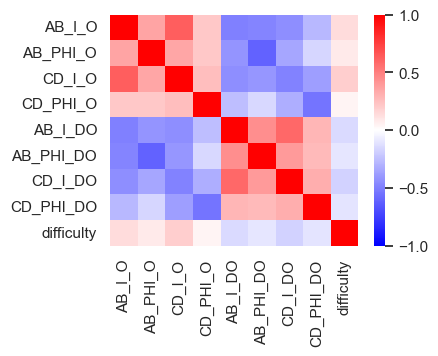

In [15]:
plt.figure(figsize=(4,3))
sns.heatmap(all_data.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.show()

- there is always an anti-correlation between oxygenated ("_O_") and deoxygenated ("_DO_") measures
- oxygenated and deoxygenated measures always have positive correlations amongst themselves
- intensity measures ("_I_") have stronger correlations than phase intensity measures ("_PH_I_")
- oxygenated intensity measures increase as task difficulty increases, whilst deoxygenated measures decrease - these correlations seem to be slightly stronger in the CD brain region, compared to the AB brain region

**quick dimensionality reduction to see if we can remove some of these correlations**
- keep 90% of variance

In [16]:
explained_variance = 0.9
X_reduced, all_data_reduced, pca = pp.pca_reduce_data(explained_variance, all_data)

Number of components remaining required to explain 90.0% of the variance is 6


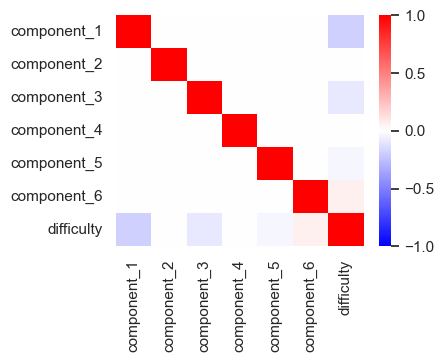

In [17]:
plt.figure(figsize=(4,3))
sns.heatmap(all_data_reduced.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.show()

- can confirm that there is no correlation between components

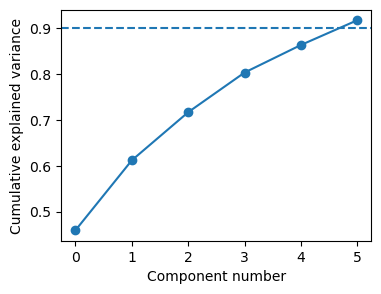

In [13]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Component number')
plt.axhline(explained_variance, ls='--')
plt.show()